In this notebook, we'll try analyzing Sylas's data of beads in networks using methods described in this [Cho et al 2020 PRL paper](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005).

The heart of the DDM code (found in the `ddm_clean.py` file) is the computation of the image structure function. This is found by taking the average of the Fourier transforms of all image *differences*. By "image differences," I mean the result of subtracting two images separated by a given lag time $\Delta t$.

To describe the process mathematically, we find the difference between images separated by some lag time $\Delta t$:
$$\Delta I = I(x,y;t) - I(x,y;t + \Delta t)$$

For a given $\Delta t$ all such image differences are calculated. We then Fourier transform each $\Delta I$ and average all of the same $\Delta t$.

This results in the image structure function $D(q_x,q_y,\Delta t)$.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 6,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 6,
              }

C:\ProgramData\Anaconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
from scipy.optimize import leastsq
import pickle #for saving data

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [4]:
reload(ddm) 

<module 'ddm_clean' from 'ddm_clean.pyc'>

<IPython.core.display.Javascript object>


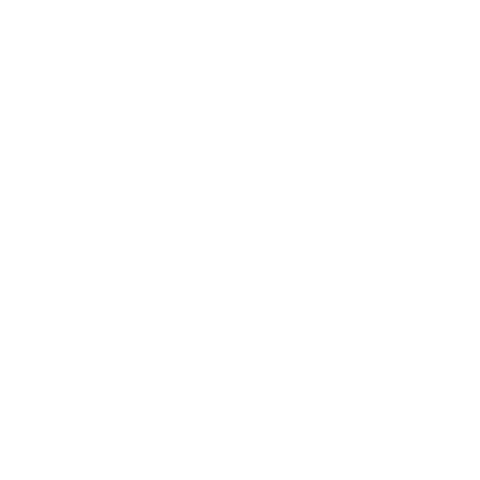

In [5]:
#Specify where the data is stored and the image data filename. Must be in tiff format
data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\19_10_15_Entangled\\DDM\\_1\\"
data_file = "_1_MMStack_Pos0.ome.tif"

#Image read using tiff_file module
im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

------------------------------------------------------
In the cell below, we generate the list of delay times. We will calculate the image structure function for only these set of lag times. 

We are also constructing a filter to multiply the images by. This filter is used to remove artifacts that might appear in the image structure function to the edges of the images. To reduce potential artifacts from the boundaries, we use a Blackman-Harris windowing function. This method was described in the [paper found here](https://arxiv.org/abs/1707.07501). 

numPixels = im.shape[1]
x,y = np.meshgrid(bh(numPixels),bh(numPixels))
filter_func = x*y
#num_pts will be the number of time lags we investigate
num_pts = 30 #usually num_pts was 400 when we have done data analysis
dts = ddm.genLogDist(1,1000,num_pts) 

The cell below will calculate the image structure function. The main function is the `ddm.getFFTDiffsAtTimes`. That function returns the averaged Fourier tranforms of all differences between images separated by the lag times in the list `dts`. 

Those image structure functions are then radially averaged with `ddm.radialAvFFTs_v2`. We can radially average when we know that the dynamics are isotropic. 

The data is then stored in a [dictionary](https://docs.python.org/2/tutorial/datastructures.html?highlight=dictionary#dictionaries) and saved to a file using the [`pickle` function](https://docs.python.org/2/library/pickle.html). 

#With Blackmann-Harris filtering of images:
#fft,dtsB = ddm.getFFTDiffsAtTimes(im[1:,0:numPixels,0:numPixels]*filter_func, dts, every=None, limitImsTo=None, submean=False)

#Without Blackmann-Harris filtering of images:
fft,dtsB = ddm.getFFTDiffsAtTimes(im[1:,0:numPixels,0:numPixels], dts, every=None, limitImsTo=None, submean=False)


ravs = ddm.radialAvFFTs_v2(fft)
dts_fft = {'dts':dts, 'ffts':fft, 'ravs':ravs}
f=open(data_dir + data_file[:-4]+"_1_128x128_FFTDIFFS_dts_ravs.p",'wb')
pickle.dump(dts_fft, f)
f.close()

---------------------------------
Since the `getFFTDiffsAtTimes` function can take several minutes (or even hours) to run if the images are large and if we find the image structure function at many lag times, it is best to always save the output to that function. That way, if you want to come back and do more analysis, you just load the saved image structure functions. Loading that saved file is done with the function `pickle.load`.

In [6]:
#open the file with or without BH filtering:
#f = open(data_dir + data_file[:-4]+"_1_BH_128x128_FFTDIFFS_dts_ravs.p",'rb')
data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\19_10_15_Entangled\\DDM\\analysis\\"
data_file = "_1_MMStack_Pos0.ome_1_256x256_FFTDIFFS_dts_ravs.p"
f = open(data_dir + data_file,'rb')
p_data = pickle.load(f)
f.close()
p_data.keys()

['dts', 'ravs', 'ffts']

In [7]:
#This is how data is stored in dictionaries
ravs = p_data['ravs']
dts = p_data['dts']

<IPython.core.display.Javascript object>


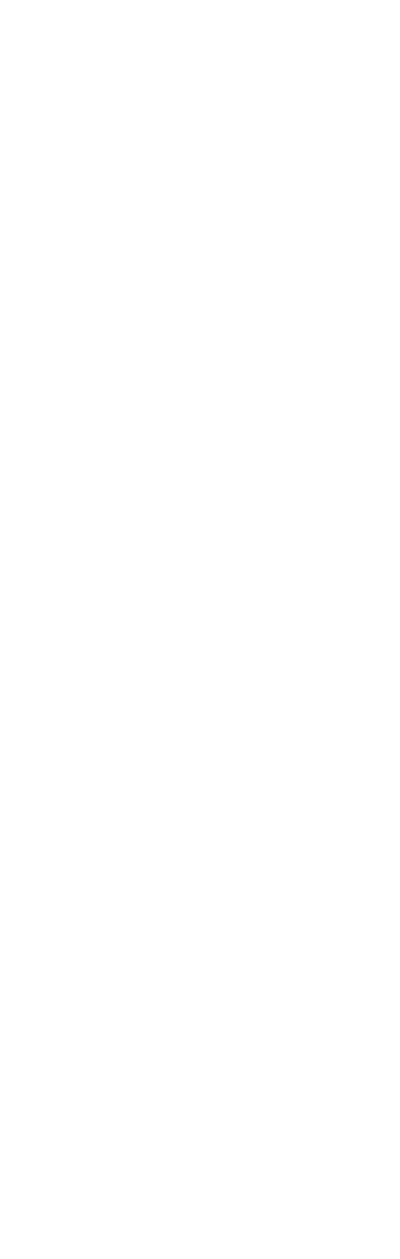

In [8]:
plt.matshow(ravs, cmap=matplotlib.cm.gray)
plt.xlabel("Spatial frequency (inverse pixels)")
plt.ylabel("Delay times");

In [9]:
fps = 10.0 #The frame rate the video data was recorded at. 
times = dts/fps #Create the list of delay times in units of seconds
pixel_size = 0.3596 
numPixels = 256
q = np.arange(0,numPixels/2)*2*np.pi*(1./(numPixels*pixel_size)) #Convert the spatial frequencies to wave vectors

<IPython.core.display.Javascript object>


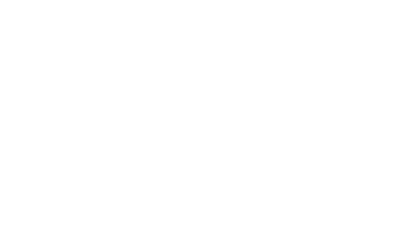

In [10]:
##########################################################################
# Here, we'll show the image structure function for a particular q-value. 
##########################################################################

qv=10
fig = plt.figure(figsize=(4,4./1.618))
plt.plot(times, ravs[:,qv],'ro')
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % qv, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.text(0.8, 0.15, 'q-value: %.2f 1/$\mu$m' % q[qv], horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)', fontdict=font_plt_ax);


--------------------------------------------------------------------------------------
Now we need to fit the image structure functions for each q-value. 

Finding the appropriate fitting function is not always straightforward. When analyzing DDM data, this fitting step is often the most time consuming and potentially frustrating. 

We will try to fit the data using the Levenberg-Marquardt least-squares minimization method implemented in the `mpfit` module. We will also use SciPy's ['leastsq' function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html). 

Both functions seem to do an okay job. One nice feature of the `mpfit` module is that you can specify the minimum and maximum values that each parameter is allowed to take. You can also easily change parameters from ones that are allowed to vary to ones that are fixed. 

One important task when doing the fitting is to come up with good initial guesses. That is what the `ddm.returnReasonableParams` tries to do in an automated fashion. However, you may need to adjust the initial guesses by hand. 

For the Levenberg-Marquardt function, in addition to giving the optimization function the best guess parameters, you give it the minimum values those parameters can take, the maximum values those paramters can take, and a Boolean array specifying whether the parameters are fixed or not. 

<IPython.core.display.Javascript object>


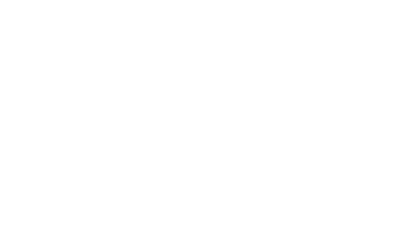

In [11]:
q_index = -1
backg = 20 #change me! <------------------------------------------

#We try to use the function `returnReasonableParams` to find reasonable initial guesses for the fitting function
pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=ravs[:,q_index], bg=backg, double=False, fps=fps)
fig = plt.figure(figsize=(4,4./1.618))
plt.plot(times, ravs[:,q_index],'ro') #plot the data
plt.plot(times, ddm.dTheory(times,*pars), '-k', lw=4) #see how well the initial guess performs
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % q_index, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)');

<IPython.core.display.Javascript object>


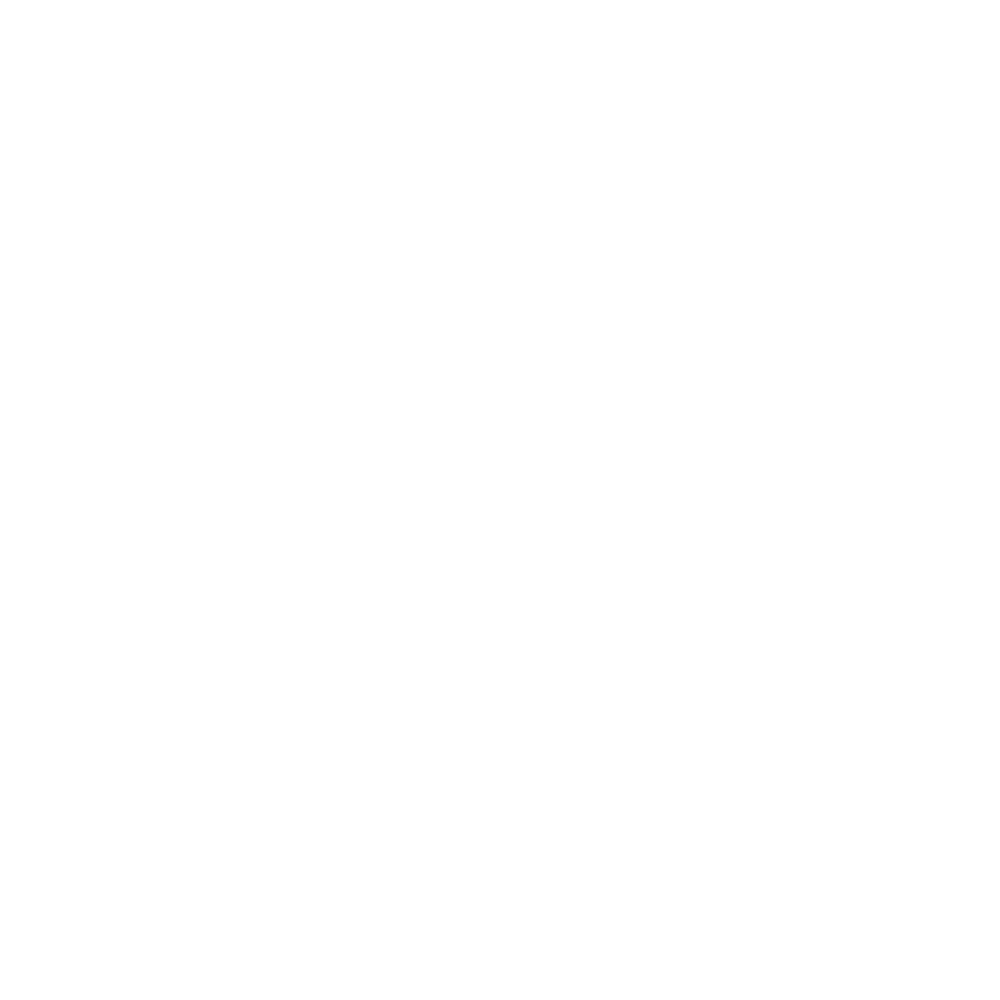

C:\ProgramData\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)
mpfit.py:2284: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


bg: 0.01000000000000002
bg: 0.010000000000000014
bg: 0.01
bg: 0.010000000000000007
bg: 0.010000000000000014
bg: 0.01
bg: 0.010000000000000012
bg: 0.01


In [12]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''

    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=backg, double=False, fps=fps)
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp) - 3, (... same for second exp..))
    
    #Decay time
    # The initial guess for this parameter will be generated automatically
    # But here we can set the minimum and maximum of the possible values. 
    maxp[1] = 1000    #The decay time can't be larger than this
    minp[1] = 0.001   #The decay time can't be smaller than this
    
    #Background
    maxp[2]=400
    minp[2]=0.01
    pars[2]=backg #This was set in the previous code block
    
    #Stretching exponent. Ideally, this should be 1.0 (which would be a normal exponential)
    minp[3]=0.15   #Can't be smaller than this
    maxp[3]=1.01  #Can't be larger than this
    pars[3]=1.0  #The initial guess. Usually, this should be 1 unless you suspect anomalous behavior. 
    
    #We can choose to allow certain paramters to vary or we can fix them.
    # In the 'fix' vector, if we set to True, the value will be fixed and not allowed to vary.
    fix[3]= False  #Determines whether we fix alpha (the stretching exponent) or not
    fix[2]= False   #Determines whether we fix the background or not.
    
    #The following is for setting parameters for the 2nd exponential. 
    #  But usually we do not use double exponential fits.
    fix[6]= False #6 is the stretching exponent for 2nd exponential
    pars[6] = 0.6
    minp[6] = 0.5 #min alpha2\n",
    maxp[6] = 0.75   #max alpha2\n",
    
    pars[5] = 0.1*pars[1] #5 is the time const for 2nd exponential
    maxp[5] = 100
    minp[5] = 0.01
    '''
    #Leave this commented out for single exponential fits
    totamp = pars[0]+pars[4] ##0 and 4 are the amplitudes
    pars[4] = 0.4*totamp
    pars[0] = 0.4*totamp
    '''

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

%matplotlib notebook
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)

q_index = 10  # 10 usually works because it tends to fit well for all types of dynamics
end_time = 300  # change this if the data plateaus early, it is where the fitting stops
#Loop over four different q-values to do the fit
for i,q_index in enumerate([5,10,15,20,25,30,35,50]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:end_time,q_index], times[:end_time])
    #print len(theoryB)
    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times[:len(theoryB)], theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.125,'Stretching exponents: %.2f' % (fitparamsB[3]), 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.06,'Amptlidue1: %.2f' % (fitparamsB[0]),
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    print "bg:", fitparamsB[2]

In [13]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fitparams, theory, chi2 = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[0]
    bg[i] = fitparams[2]
    tau[i] = fitparams[1]
    alph[i] = fitparams[3]

ddm_clean.py:243: RuntimeWarning: invalid value encountered in power
  g1 = np.exp(-1 * (x / t1)**s1)


--------------------
You now will want to inspect the discovered fit parameters. You may need to adjust things (maybe fix certain parameters or allow others, like the background, to vary). 

Often, the parameter we are most interested in is the `tau` parameter -- the decay time. 

For normal diffusive dynamics, we expect that the decay time is inversely proportional to the wave vector squared. The constant of proportionality is 1/D where D is the diffusion coefficient. So we will plot the decay time versus q on a log-log plot. If the dynamics follow normal diffusion, then we should see that the data follows a straight line with a slope of -2. 

<IPython.core.display.Javascript object>


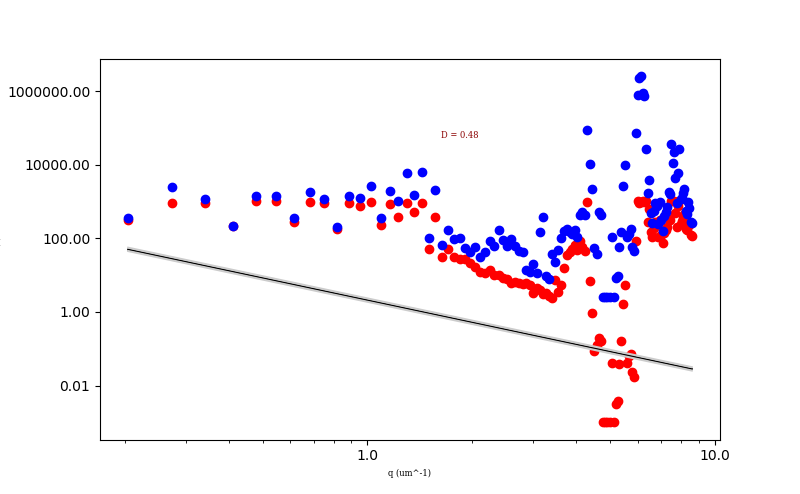

<IPython.core.display.Javascript object>


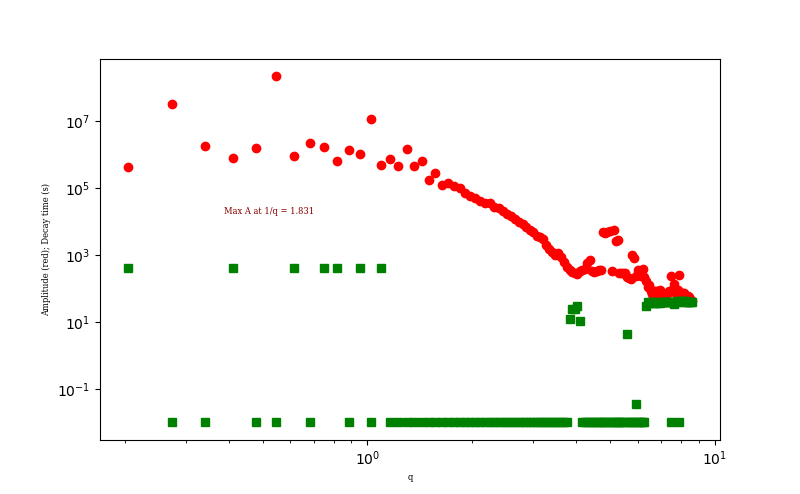

In [14]:
%matplotlib notebook

#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau[2:-1],alph[2:-1]),'bo')
diffusion_coeff = 0.48
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
diffusion_coeff_2 = 0.53
ax.plot(q[3:-1], (1./diffusion_coeff_2) * 1./(q[3:-1]**2), '-', c='0.8')
diffusion_coeff_3 = 0.43
ax.plot(q[3:-1], (1./diffusion_coeff_3) * 1./(q[3:-1]**2), '-', c='0.8')
ax.set_xlabel("q (um^-1)", fontdict=font_plt_ax)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.1f}'.format))
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
ax.text(0.55,0.8,'D = %.2f' % diffusion_coeff, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)

#Plot the amplitude versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], amp[2:-1], 'ro')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[3:-1][w]
ax.loglog(q[3:-1], bg[2:-1], 'gs') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)
ax.text(0.2,0.6,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);


Notice that the decay time versus q follows the expected line fairly well. However, there is some error at the very low and very high q values. At the low-q values, the dynamics are slow (it takes longer for larger scale density fluctuations to decay). Therefore, we might need to take *longer* movies to access those low-q values. But we will likely still see that the data at the very lowest q-values isn't great. At the highest q-values, we see that the background exceeds (by as much as an order of magnitude) the amplitude. Therefore, there is too much noise. One could try to access the higher q-values by recording movies at a faster frame rate (since small spatial scale fluctuations decay quickly) or by imaging with a greater numerical aperture or greater magnification (increasing the resolution). 

Below, we will connect the diffusion coefficient found above (about 0.48 micron^2/s) to the particle radius.

<IPython.core.display.Javascript object>


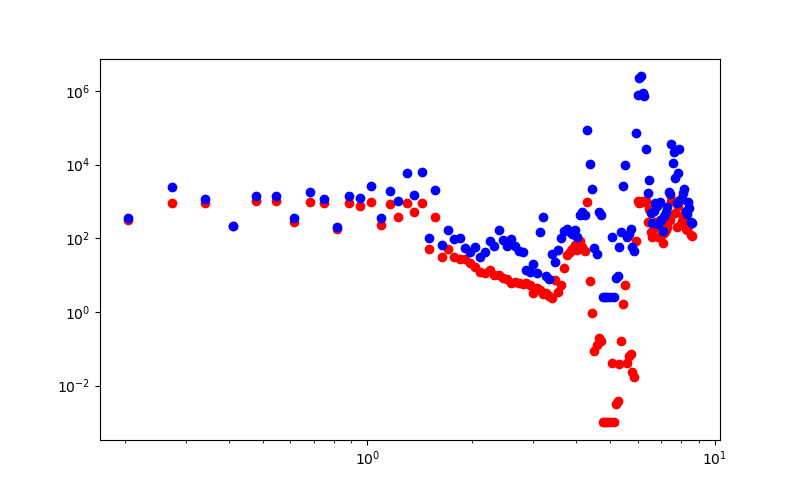

In [15]:
#Fitting with the "good" wave vectors to find the diffusion coefficient

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau[2:-1],alph[2:-1]),'bo')



## New method for getting A and B

In [16]:
nframes, ndx, ndy = im[:,256:512,0:256].shape
print("Our image has %i frames and each frame is %i x %i pixels" % (nframes, ndx,ndy))

Our image has 5000 frames and each frame is 256 x 256 pixels


In [17]:
#get the average abs(fft)^2 for each frame
av_fftsq_of_each_frame = np.zeros_like(im[0,256:512,0:256]*1.0)
for i in range(0, nframes):
    fft_of_image = np.fft.fft2(im[i,256:512,0:256]*1.0)
    sqr_of_fft = np.fft.fftshift(fft_of_image*np.conj(fft_of_image))
    av_fftsq_of_each_frame = av_fftsq_of_each_frame + abs(sqr_of_fft)
av_fftsq_of_each_frame = av_fftsq_of_each_frame/(1.0*nframes*ndx*ndy)

<IPython.core.display.Javascript object>


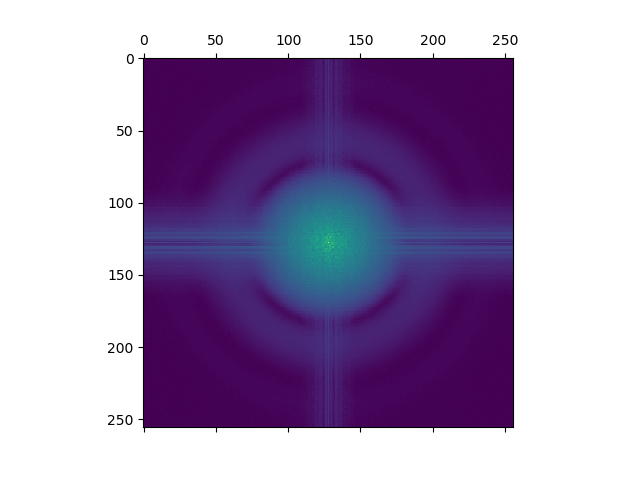

In [18]:
plt.figure()
plt.matshow(np.log(av_fftsq_of_each_frame),fignum=0)

In [19]:
#give the radially averaging function a 3d array because that is what it was written to take
rad_av_av_fftsq = ddm.radialAvFFTs_v2(av_fftsq_of_each_frame.reshape(1,ndx,ndy))

<IPython.core.display.Javascript object>


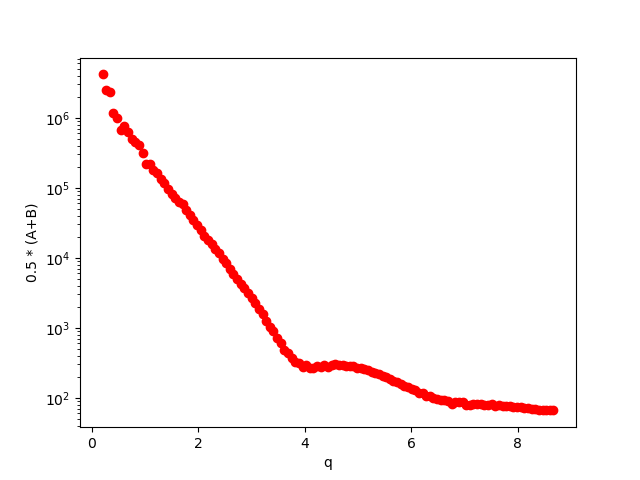

Text(0,0.5,'0.5 * (A+B)')

In [20]:
plt.figure()
plt.semilogy(q[3:], rad_av_av_fftsq[0,2:],'ro')
plt.xlabel("q")
plt.ylabel("0.5 * (A+B)")

Based off of the DDM data, I'd say the background is ~ 40. 
Based off the above plot, seems like it (1/2)(A+B) is plateauing at high q to around 50. So B is around 130. 

In [21]:
#Testing either 100 or 40 as background to use, seems 40 is better
background = 40
new_amplitude = (2*rad_av_av_fftsq[0]) - background

<IPython.core.display.Javascript object>


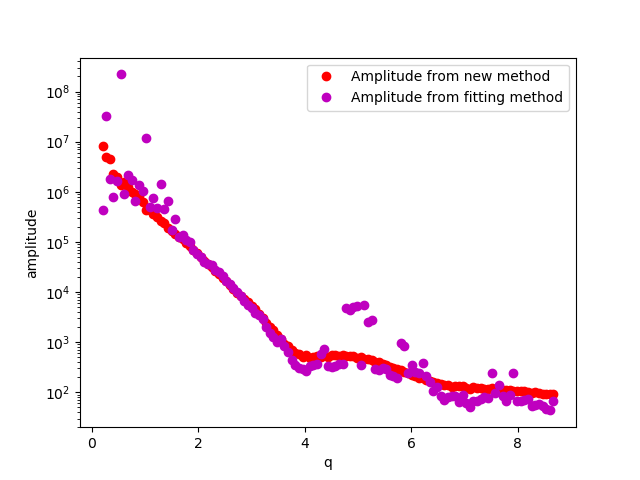

In [22]:
plt.figure()
plt.semilogy(q[3:], new_amplitude[2:], 'ro', label='Amplitude from new method')
plt.plot(q[3:], amp[2:], 'mo', label='Amplitude from fitting method')
plt.xlabel("q")
plt.ylabel("amplitude")
plt.legend(loc=0)

In [23]:
ravs.shape

(400L, 127L)

Based on our new value for amplitude, let's find the intermediate scattering function

In [24]:
#Just double checking sizes of arrays:
print("size of ravs array (the ddm matrix or image struct func): %i by %i" % ravs.shape)
print("size of new amplitudes: %i" % new_amplitude.shape)

size of ravs array (the ddm matrix or image struct func): 400 by 127
size of new amplitudes: 127


In [25]:
#Initialize arrays to store the ISF (intermediate scattering function)
isf = np.zeros_like(ravs) #decay time

for i in range(1,ravs.shape[1]):
    isf[:,i] = 1 - ((ravs[:,i] - background) / new_amplitude[i])

<IPython.core.display.Javascript object>


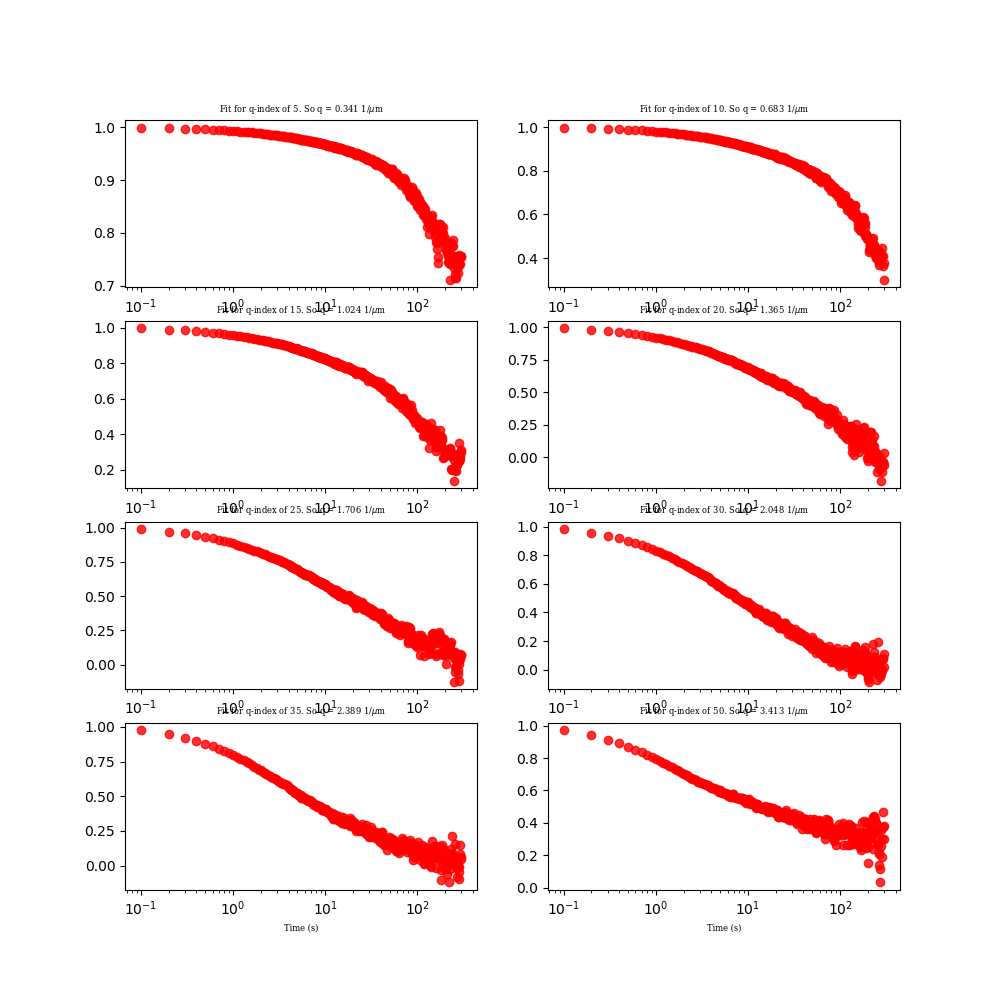

In [26]:
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([5,10,15,20,25,30,35,50]):

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,isf[:,q_index],'ro',alpha=0.8)
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)

In [27]:
def errorfunc_for_scipy_leastsq_fit(params, data, times):
    theory = ddm.dTheoryNonErgISF(times, params[0],params[1],params[2])
    return data-theory
    

def isf_fitting(data, times):
    '''
    This function does the ISF fitting. 

    We'll just use one round. Using Levenberg-Marquardt method with the mpfit module. 
    '''
    
    #Our parameters are: c (non-ergodicity param), tau, stretching epxonent
    pars = np.zeros(3)*1.0
    minp = np.zeros_like(pars)
    maxp = np.zeros_like(pars)
    lmin = np.array([True, True, True])
    lmax = np.array([True, True, True])
    fix = np.array([False, False, False])
    
    #come up with limits:
    minp[0] = 0.0 #minimum non-erg parameter
    maxp[0] = 1.0 #maximum non-erg parameter
    minp[1] = 0.1 #minimum decay time
    maxp[1] = 3000.0  #maximum decay time
    minp[2] = 0.1 #minimum stretching exponent
    maxp[2] = 0.9 #maximum stretching exponent
    
    #initial guesses (maybe should use tau from earlier fits to D(q,t)?)
    pars[0] = 0.01 #non-ergodicity parameter
    pars[1] = 50.0 #decay time
    pars[2] = 0.65 #stretching exponent
    
    fitparams_lstsq_temp = leastsq(errorfunc_for_scipy_leastsq_fit, pars, args=(data,times))
    fitparams_isf_lstsq = fitparams_lstsq_temp[0]
    theory_isf_lstsq = ddm.dTheoryNonErgISF(times, fitparams_isf_lstsq[0], fitparams_isf_lstsq[1], fitparams_isf_lstsq[2])
    

    for i in range(3):
        if fitparams_isf_lstsq[i] > maxp[i]:
            pars[i] = 0.99*maxp[i]
        elif fitparams_isf_lstsq[i] < minp[i]:
            pars[i] = 1.01*minp[i]
        else:
            pars[i] = fitparams_isf_lstsq[i]

    

    fitparams_isf, theory_isf, errCode, chi2 = ddm.newFit_ISF(data,times,pars,minp,maxp,lmin,lmax,fix,
                                                              logfit=False,quiet=True,factor=0.1)
    
    return fitparams_isf, theory_isf, chi2, fitparams_isf_lstsq, theory_isf_lstsq


<IPython.core.display.Javascript object>


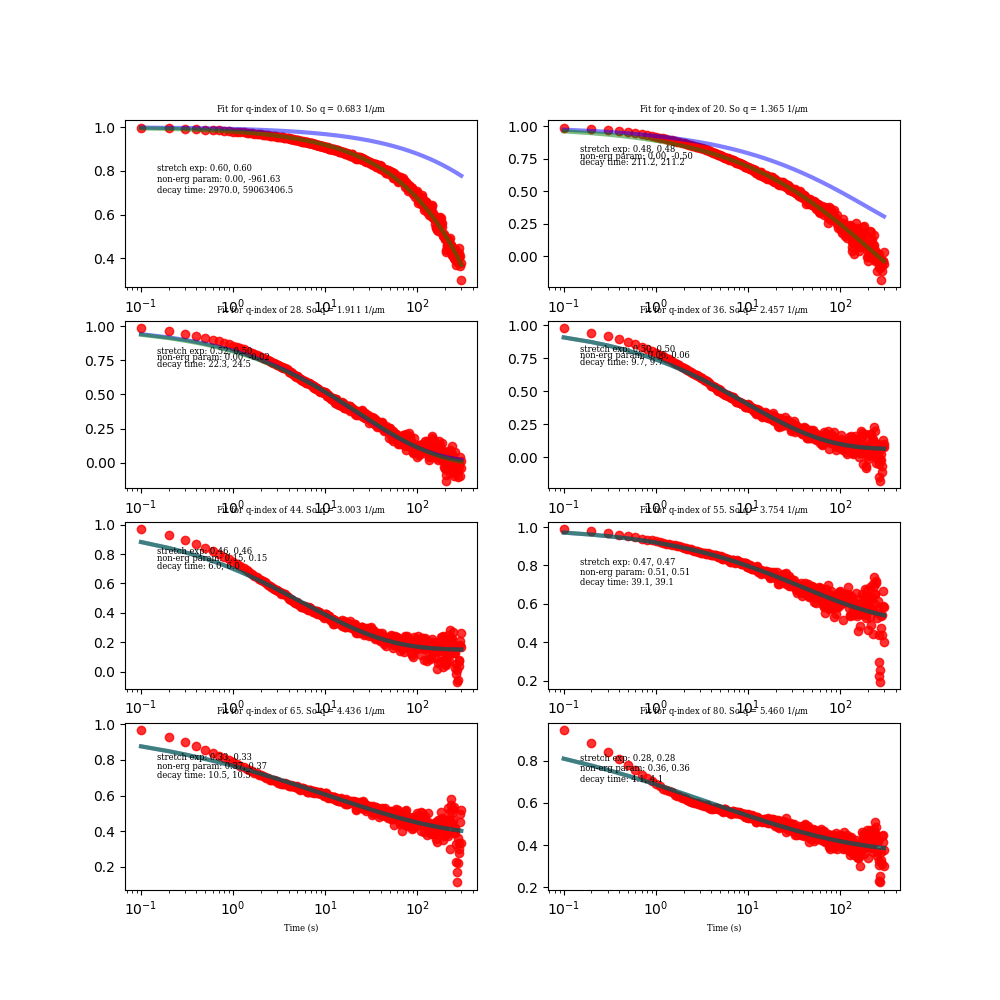

C:\ProgramData\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)
ddm_clean.py:272: RuntimeWarning: invalid value encountered in power
  g1 = np.exp(-1.0*(x/t)**s)


In [28]:
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)



#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([10,20,28,36,44,55,65,80]):
    
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:,q_index],times)

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,isf[:,q_index],'ro',alpha=0.8)
    ax.semilogx(times, theory_isf,'-b',lw=3,alpha=0.5) #BLUE LINE: Leven-Marq fitting method
    ax.semilogx(times, theory_isf_lstsq,'-g',lw=3,alpha=0.5) #GREEN LINE: scipy.optimize's leastsquares function
    
    ax.text(0.15,0.7, "decay time: %.1f, %.1f" % (fp_isf[1], fp_isf_lstsq[1]), fontdict=font_plt_ax)
    ax.text(0.15,0.75, "non-erg param: %.2f, %.2f" % (fp_isf[0], fp_isf_lstsq[0]), fontdict=font_plt_ax)
    ax.text(0.15,0.8, "stretch exp: %.2f, %.2f" % (fp_isf[2], fp_isf_lstsq[2]), fontdict=font_plt_ax)
    
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)

In [29]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau_v2 = np.zeros_like(ravs[0,:]) #decay time
c = np.zeros_like(tau) #amplitude
alph_v2 = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fp_isf, theory_isf, chi2, fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:,i],times)
    c[i] = fp_isf[0]
    tau_v2[i] = fp_isf[1]
    alph_v2[i] = fp_isf[2]

<IPython.core.display.Javascript object>


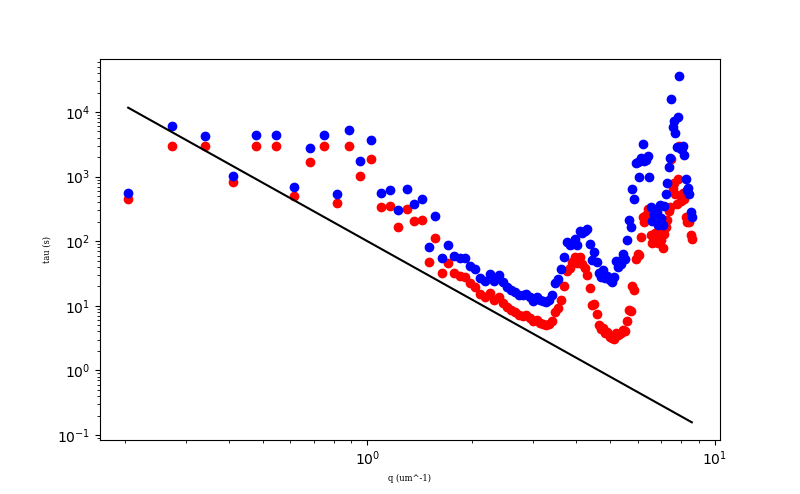

<IPython.core.display.Javascript object>


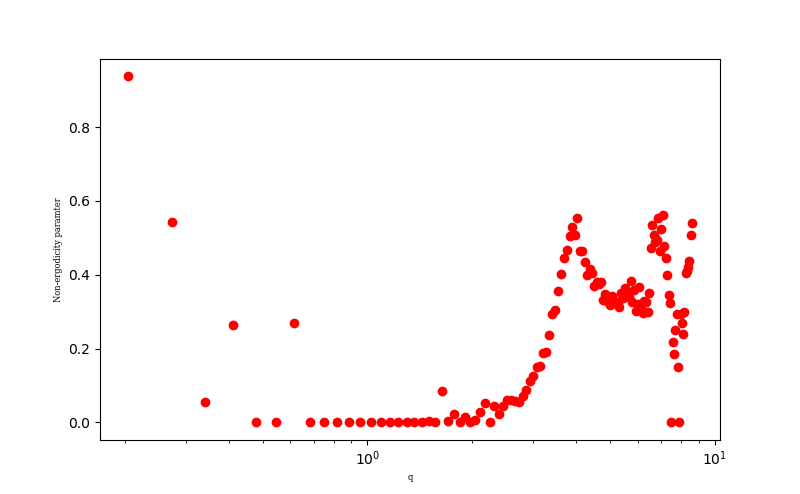

<IPython.core.display.Javascript object>


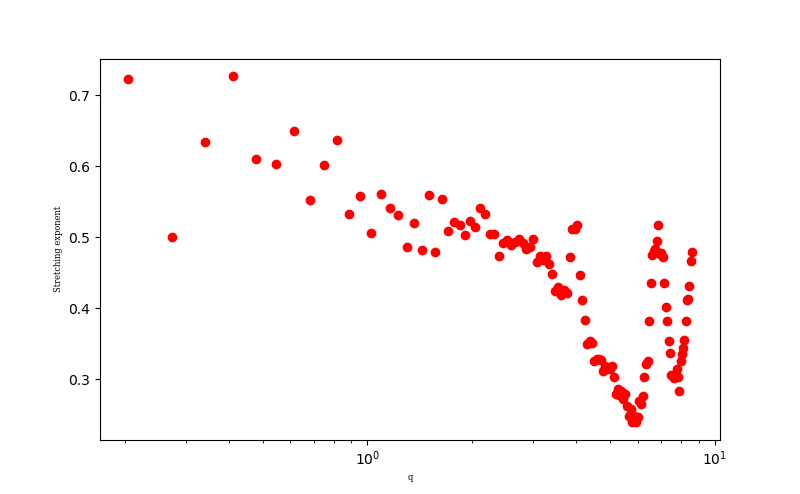

Text(0,0.5,'Stretching exponent')

In [32]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau_v2[2:-1], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau_v2[2:-1],alph_v2[2:-1]),'bo')

ax.set_xlabel("q (um^-1)", fontdict=font_plt_ax)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
k = 0.01
ax.plot(q[3:-1], (1./k) * 1./(q[3:-1]**3), '-k')


#Plot the non-erg parameter versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.semilogx(q[3:-1], c[2:-1], 'ro')

ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Non-ergodicity paramter", fontdict=font_plt_ax)

#Plot the stretching exponent versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.semilogx(q[3:-1], alph_v2[2:-1], 'ro')

ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Stretching exponent", fontdict=font_plt_ax)
